In [1]:
# following codes were tested with Anaconda environment online.

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

In [2]:
from time import process_time

In [3]:
import tensorflow as tf
# GPU was recognized by installing cudatoolkit :
# conda install cudatoolkit=10.1

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4292330594581169605
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3684943995766379870
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2409190838896450523
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9307756051485045488
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10562779264
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11149006695393165127
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10246566720
locality {
  bus_id: 1
  links {
  }
}
incarnation: 914

In [6]:
# tf.test.gpu_device_name()
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [7]:
from platform import python_version

print(python_version())

3.7.9


In [8]:
keras.__version__

'2.4.0'

In [9]:
tf.__version__

'2.3.0'

In [10]:
img_height=400
img_width=518
batch_size=32

In [11]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    '../data',labels='inferred',label_mode='int',
    validation_split=0.2, subset='training',
    seed=123,color_mode='grayscale',
    image_size=(img_height,img_width),
    batch_size=batch_size
    )

Found 671 files belonging to 2 classes.
Using 537 files for training.


In [12]:
val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    '../data',labels='inferred',label_mode='int',
    validation_split=0.2, subset='validation',
    seed=123,color_mode='grayscale',
    image_size=(img_height,img_width),
    batch_size=batch_size
    )

Found 671 files belonging to 2 classes.
Using 134 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['par1', 'wt']


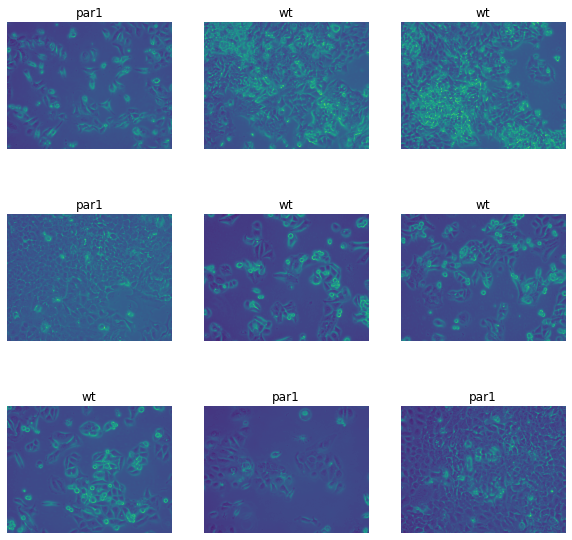

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for images,labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [15]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 400, 518, 1)
(32,)


In [16]:
# Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. 
# These are two important methods you should use when loading data.

# Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. 
# This will ensure the dataset does not become a bottleneck while training your model. 
# If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk 
# cache.

# Dataset.prefetch() overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
# This is for normalization foorr RBG channel. We used Grayscale, so search whether this is required 
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [18]:
num_classes = 2

In [19]:
# Create the model (Note that below model does not contain drop out)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'), #original 128
#   layers.Dense(512, activation='softmax'), #original 128
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 400, 518, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 400, 518, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 200, 259, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 259, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 129, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 129, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 64, 128)       0

In [22]:
# on CPU only : 32 min.
# using GPU : 1 min 18s

t0_start=process_time()

epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
t0_stop=process_time()
print("Elapsed time: ", t0_stop, t0_start)
print("Time for total "+str(epochs) +" epochs : "+str((t0_stop-t0_start)/600) +" min.")

Epoch 1/100
17/17 [==============================] - 19s 1s/step - loss: 3.5614 - accuracy: 0.5736 - val_loss: 0.6827 - val_accuracy: 0.6418
Epoch 2/100
17/17 [==============================] - 2s 97ms/step - loss: 0.6483 - accuracy: 0.6611 - val_loss: 0.6412 - val_accuracy: 0.6418
Epoch 3/100
17/17 [==============================] - 2s 97ms/step - loss: 0.6441 - accuracy: 0.6611 - val_loss: 0.6713 - val_accuracy: 0.6418
Epoch 4/100
17/17 [==============================] - 2s 97ms/step - loss: 0.6533 - accuracy: 0.6611 - val_loss: 0.6707 - val_accuracy: 0.6418
Epoch 5/100
17/17 [==============================] - 2s 97ms/step - loss: 0.6467 - accuracy: 0.6611 - val_loss: 0.6360 - val_accuracy: 0.6418
Epoch 6/100
17/17 [==============================] - 2s 96ms/step - loss: 0.6183 - accuracy: 0.6611 - val_loss: 0.6423 - val_accuracy: 0.6418
Epoch 7/100
17/17 [==============================] - 2s 96ms/step - loss: 0.6184 - accuracy: 0.6611 - val_loss: 0.6940 - val_accuracy: 0.6418
Epoch 8

17/17 [==============================] - 2s 98ms/step - loss: 3.4561e-06 - accuracy: 1.0000 - val_loss: 4.1042 - val_accuracy: 0.5522
Epoch 56/100
17/17 [==============================] - 2s 98ms/step - loss: 3.2069e-06 - accuracy: 1.0000 - val_loss: 4.1229 - val_accuracy: 0.5522
Epoch 57/100
17/17 [==============================] - 2s 98ms/step - loss: 3.0517e-06 - accuracy: 1.0000 - val_loss: 4.1452 - val_accuracy: 0.5522
Epoch 58/100
17/17 [==============================] - 2s 98ms/step - loss: 2.8978e-06 - accuracy: 1.0000 - val_loss: 4.1704 - val_accuracy: 0.5522
Epoch 59/100
17/17 [==============================] - 2s 98ms/step - loss: 2.7282e-06 - accuracy: 1.0000 - val_loss: 4.1896 - val_accuracy: 0.5522
Epoch 60/100
17/17 [==============================] - 2s 98ms/step - loss: 2.6141e-06 - accuracy: 1.0000 - val_loss: 4.2136 - val_accuracy: 0.5522
Epoch 61/100
17/17 [==============================] - 2s 98ms/step - loss: 2.4734e-06 - accuracy: 1.0000 - val_loss: 4.2293 - val_a

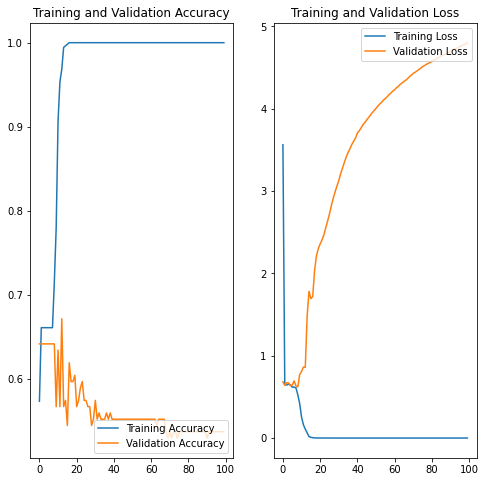

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
# Above graph indicates the sign of overfitting. Let's increase the dataset by augmentation

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal",
                                                    input_shape=(img_height,img_width,1)),
        layers.experimental.preprocessing.RandomFlip("vertical"),
#         layers.experimental.preprocessing.RandomRotation(0.1, input_shape=(img_height,img_width,1))
        layers.experimental.preprocessing.RandomRotation(0.1)
    ]
)

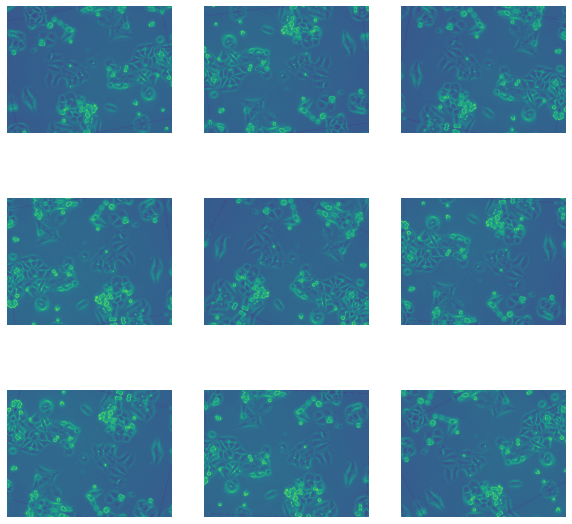

In [25]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax=plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

In [26]:
# Also, dropout technique helps reduce overfitting

# test with more filters : 32-64-128
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
#     layers.Conv2D(16, 3, padding='same', activation='relu'), # test09 conv2d 16-32-mp-64-mp-0.2-128-mp-0.2-f-256 *prediction failed
#     layers.Conv2D(32, 3, padding='same', activation='relu'), # test10 conv2d 32-32-mp-64-mp-0.2-128-mp-0.2-f-256 *prediction failed
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
#     layers.Dropout(0.2), # newly added for test07 0.2-0.2-0.2-512
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
#     layers.Dropout(0.2), # newly added for test06 0.2-0.2-512
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4), # test16:0.4-256-lr0.0005
    layers.Flatten(),
    layers.Dropout(0.4), # test16:0.3-f-0.3-256-lr0.0005
    layers.Dense(256, activation='relu'), # or softmax #test08: 0.2.-0.2-256
    layers.Dropout(0.4), # test16:0.3-f-0.3-256-lr0.0005
#     layers.Dense(512, activation='softmax'), # softmax failed
    layers.Dense(num_classes)
    
])

# perhaps we need smaller dense layer? (ucohead used 32)

In [27]:
opt=keras.optimizers.Adam(learning_rate=0.001) #default lr=0.001
model.compile(optimizer=opt,
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 400, 518, 1)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 400, 518, 1)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 400, 518, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 200, 259, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 200, 259, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 100, 129, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 100, 129, 128)    

In [29]:
t1_start=process_time()

epochs = 200 #test11: epoch 200 (0.2.-0.2-256) not saved / test11: 200 for (0.2-256) /test13: 200 for 0.3-256 / test14:lr0.0002
# test15: lr 0.0005 #test17: 0.2-0.2-256-lr0.0002
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

t1_stop=process_time()
print("Elapsed time: ", t1_stop, t1_start)
print("Time for total "+str(epochs) +" epochs : "+str((t1_stop-t1_start)/600) +" min.")

Epoch 1/200
17/17 [==============================] - 2s 110ms/step - loss: 1.5107 - accuracy: 0.5624 - val_loss: 0.6591 - val_accuracy: 0.6418
Epoch 2/200
17/17 [==============================] - 2s 103ms/step - loss: 0.6501 - accuracy: 0.6611 - val_loss: 0.6586 - val_accuracy: 0.6418
Epoch 3/200
17/17 [==============================] - 2s 103ms/step - loss: 0.6482 - accuracy: 0.6592 - val_loss: 0.6392 - val_accuracy: 0.6418
Epoch 4/200
17/17 [==============================] - 2s 104ms/step - loss: 0.6543 - accuracy: 0.6611 - val_loss: 0.6505 - val_accuracy: 0.6418
Epoch 5/200
17/17 [==============================] - 2s 104ms/step - loss: 0.6475 - accuracy: 0.6611 - val_loss: 0.6395 - val_accuracy: 0.6418
Epoch 6/200
17/17 [==============================] - 2s 104ms/step - loss: 0.6381 - accuracy: 0.6592 - val_loss: 0.6378 - val_accuracy: 0.6418
Epoch 7/200
17/17 [==============================] - 2s 104ms/step - loss: 0.6305 - accuracy: 0.6611 - val_loss: 0.6301 - val_accuracy: 0.6418

17/17 [==============================] - 2s 104ms/step - loss: 0.2522 - accuracy: 0.8901 - val_loss: 0.2523 - val_accuracy: 0.9104
Epoch 57/200
17/17 [==============================] - 2s 104ms/step - loss: 0.2522 - accuracy: 0.8939 - val_loss: 0.2190 - val_accuracy: 0.9254
Epoch 58/200
17/17 [==============================] - 2s 104ms/step - loss: 0.2587 - accuracy: 0.9125 - val_loss: 0.5862 - val_accuracy: 0.8134
Epoch 59/200
17/17 [==============================] - 2s 103ms/step - loss: 0.2800 - accuracy: 0.8939 - val_loss: 0.4137 - val_accuracy: 0.8955
Epoch 60/200
17/17 [==============================] - 2s 103ms/step - loss: 0.2846 - accuracy: 0.8808 - val_loss: 0.2116 - val_accuracy: 0.9328
Epoch 61/200
17/17 [==============================] - 2s 104ms/step - loss: 0.2757 - accuracy: 0.8864 - val_loss: 0.3447 - val_accuracy: 0.8881
Epoch 62/200
17/17 [==============================] - 2s 104ms/step - loss: 0.2580 - accuracy: 0.9032 - val_loss: 0.2161 - val_accuracy: 0.9254
Epoch

Epoch 113/200
17/17 [==============================] - 2s 104ms/step - loss: 0.1717 - accuracy: 0.9423 - val_loss: 0.1090 - val_accuracy: 0.9552
Epoch 114/200
17/17 [==============================] - 2s 104ms/step - loss: 0.1661 - accuracy: 0.9423 - val_loss: 0.1532 - val_accuracy: 0.9478
Epoch 115/200
17/17 [==============================] - 2s 104ms/step - loss: 0.1470 - accuracy: 0.9497 - val_loss: 0.1140 - val_accuracy: 0.9627
Epoch 116/200
17/17 [==============================] - 2s 105ms/step - loss: 0.1580 - accuracy: 0.9516 - val_loss: 0.1007 - val_accuracy: 0.9627
Epoch 117/200
17/17 [==============================] - 2s 104ms/step - loss: 0.1671 - accuracy: 0.9441 - val_loss: 0.1158 - val_accuracy: 0.9552
Epoch 118/200
17/17 [==============================] - 2s 105ms/step - loss: 0.1512 - accuracy: 0.9385 - val_loss: 0.1605 - val_accuracy: 0.9627
Epoch 119/200
17/17 [==============================] - 2s 104ms/step - loss: 0.1304 - accuracy: 0.9553 - val_loss: 0.1162 - val_ac

17/17 [==============================] - 2s 104ms/step - loss: 0.0828 - accuracy: 0.9702 - val_loss: 0.3420 - val_accuracy: 0.9328
Epoch 170/200
17/17 [==============================] - 2s 104ms/step - loss: 0.1198 - accuracy: 0.9497 - val_loss: 0.2552 - val_accuracy: 0.9478
Epoch 171/200
17/17 [==============================] - 2s 104ms/step - loss: 0.0928 - accuracy: 0.9702 - val_loss: 0.1835 - val_accuracy: 0.9701
Epoch 172/200
17/17 [==============================] - 2s 104ms/step - loss: 0.0825 - accuracy: 0.9721 - val_loss: 0.0925 - val_accuracy: 0.9701
Epoch 173/200
17/17 [==============================] - 2s 103ms/step - loss: 0.1109 - accuracy: 0.9609 - val_loss: 0.0949 - val_accuracy: 0.9627
Epoch 174/200
17/17 [==============================] - 2s 103ms/step - loss: 0.1267 - accuracy: 0.9534 - val_loss: 0.2085 - val_accuracy: 0.9552
Epoch 175/200
17/17 [==============================] - 2s 104ms/step - loss: 0.1141 - accuracy: 0.9628 - val_loss: 0.1049 - val_accuracy: 0.9552

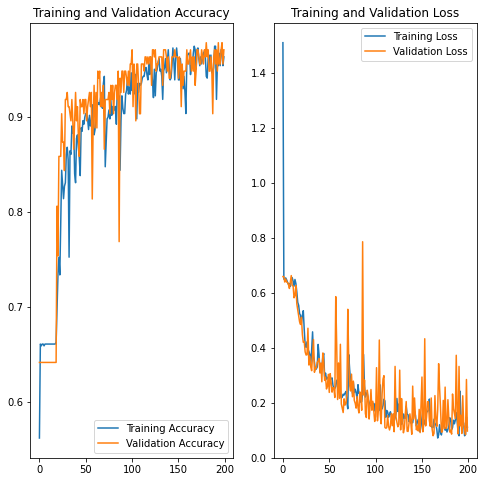

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
import pandas as pd
# df = pd.DataFrame(history)
# df.to_csv(index=False)
df = pd.DataFrame(history.history.values())
df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,1.510738,0.650059,0.648188,0.654273,0.647462,0.638089,0.630539,0.633669,0.623686,0.643224,...,0.079650,0.242119,0.153781,0.140730,0.130294,0.125849,0.079637,0.085707,0.147573,0.110838
1,0.562384,0.661080,0.659218,0.661080,0.661080,0.659218,0.661080,0.661080,0.661080,0.661080,...,0.973929,0.918063,0.955307,0.953445,0.966480,0.953445,0.970205,0.970205,0.953445,0.962756
2,0.659079,0.658635,0.639244,0.650461,0.639456,0.637835,0.630126,0.615958,0.639716,0.662847,...,0.332028,0.115384,0.154112,0.087914,0.225210,0.119136,0.106881,0.083588,0.284515,0.096734
3,0.641791,0.641791,0.641791,0.641791,0.641791,0.641791,0.641791,0.641791,0.641791,0.641791,...,0.955224,0.970149,0.947761,0.977612,0.955224,0.955224,0.970149,0.977612,0.955224,0.970149


In [32]:
df.to_csv('../test_w_increased01_results001.csv') 
#17 for dropout 0.4-0.4 / #18 for dropout 0.3-0.4-0.4 / #19 lr=0.0002/ #20 lr=0.001/#21 0.0007 / #21 0.0009 /#22 0.0009 / #23 0.001

In [33]:
img = keras.preprocessing.image.load_img(
#       '../test_images/par1_early_008.jpg',
           '../test_images/par1_late_061.jpg',
#     '../test_images/wt_early_067.jpg', 
#     '../test_images/wt_late_048.jpg', 
    color_mode='grayscale', target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to par1 with a 99.99 percent confidence.
